# Federal Election Results 2020-2010 (every 2 years)

In [89]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import cartopy.io.shapereader as shpreader
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import matplotlib.patches as mpatches
import geopandas as gpd

import psycopg2
from sqlalchemy import create_engine

In [90]:
# modeling libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [91]:
# import psycopg2
# from sqlalchemy import create_engine

# Replace the values below with your database credentials
DATABASE = "electiondb"
USER = "postgres"
PASSWORD = "Spanques&Gum6"
HOST = "localhost"
PORT = "5432"

# Connect to your PostgreSQL database
conn = psycopg2.connect(
    database=DATABASE,
    user=USER,
    password=PASSWORD,
    host=HOST,
    port=PORT
)

# Create a sqlalchemy engine
engine = create_engine(f"postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}")

# Query the table and store the results in a Pandas dataframe
results_df = pd.read_sql_query("SELECT * FROM results", conn)
voters_df = pd.read_sql_query("SELECT * FROM voters", conn)

# Commit the changes to the database
conn.commit()

# Close the database connection
conn.close()


In [92]:
# Show new dataframe
results_df.head()
# 4278 cells of 6112 rows with 7 columns. 
# 36659 cells and 5237 rows  
# The size of the 'electiondb' database is 11 mb.

,Year,Office,State,Last Name,Party,Vote %,Vote count
0,2020,Pres,AL,Trump,REP,0.620316,1441170
1,2020,Pres,AL,Biden,DEM,0.365700,849624
2,2020,Pres,AL,Jorgensen,IND,0.010836,25176
3,2020,Pres,AK,Trump,REP,0.528331,189951
4,2020,Pres,AK,Biden,DEM,0.427720,153778


In [93]:
voters_df.head()

,Year,State,Population,Registered,Voted,Norm_Voter_Reg,Norm_Voter_Pop
0,2020,AL,3769.0,2527,2247,0.889197,0.596179
1,2020,AK,528.0,383,330,0.861619,0.625000
2,2020,AZ,5638.0,3878,3649,0.940949,0.647215
3,2020,AR,2283.0,1361,1186,0.871418,0.519492
4,2020,CA,30342.0,18001,16893,0.938448,0.556753


In [32]:
# something above messed up my colors here This was working.
# map that defines the party wins by state for each office.
# Define colors for each party
colors = {'REP': 'red', 'DEM': 'dodgerblue', 'IND': 'orange'}

# Define color labels
color_labels = {'REP': 'Republican', 'DEM': 'Democrat', 'IND': 'Independent'}

# Aggregate the data by year, state, and office, and calculate the party with the highest vote percentage
vote_agg_house_df = results_df[results_df['Office']=='House'].groupby(['Year', 'State', 'Office']).apply(lambda x: x.loc[x['Vote %'].idxmax()])[['Vote %', 'Party']].reset_index()

# Map the winner of each state to colors
vote_agg_house_df['colors'] = vote_agg_house_df['Party'].map(colors)

# Create choropleth maps with custom color labels for each office
fig_house = px.choropleth(vote_agg_house_df, 
                    locations='State',
                    locationmode='USA-states',
                    color='Party',
                    scope='usa',
                    color_discrete_map=colors,
                    hover_data={'State': True, 'Office': True, 'Vote %': True},
                    title='US House Election Results: Highest Vote % between 2010 and 2020')

# Update the color scale labels for all three figures
for fig in [fig_house]:
    fig.update_layout(coloraxis_colorbar=dict(title='Party', tickvals=['REP', 'DEM', 'IND'], 
                                          ticktext=[color_labels[x] for x in ['REP', 'DEM', 'IND']]))

# Display all three figures
display(fig_house)
# display(fig_senate)
# display(fig_pres)

In [33]:
# Regions: west=w, southwest=sw, midwest=mw, northeast=ne, southeast=se, t=territories
w = ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'CO', 'AK', 'HI']
sw = ['AZ', 'NM', 'TX', 'OK']
mw = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']
ne = ['ME', 'NH', 'VT', 'MA', 'NY', 'RI', 'CT', 'NJ', 'PA', 'MD']
se = ['DE', 'WV', 'DC', 'VA', 'KY', 'TN', 'NC', 'SC', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL']
# Territories: American Samoa=AS, Guam=GU, Northern Mariana Islands=MP, Puerto Rico=PR, Trust Territories=TT, Virgin Islands=VI,
t = ['AS', 'GU', 'MP', 'PR', 'TT', 'VI']


# Create a dictionary to map states to regions
# Regions, west=w, southwest=sw, midwest=mw, northeast=ne, southeast=se
# Territories: American Samoa=AS, Guam=GU, Northern Mariana Islands=MP, Virgin Islands=VI
region_dict = {
    'w': ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'CO', 'AK', 'HI'],
    'sw': ['AZ', 'NM', 'TX', 'OK'],
    'mw': ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH'],
    'ne': ['ME', 'NH', 'VT', 'MA', 'NY', 'RI', 'CT', 'NJ', 'PA', 'MD'],
    'se': ['DE', 'WV', 'DC', 'VA', 'KY', 'TN', 'NC', 'SC', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL'],
    't': ['AS', 'GU', 'MP', 'VI']
}

# Linear Regression model

In [34]:
# Drop unnecessary columns
df = results_df.drop(['Office', 'State', 'Last Name'], axis=1)

# Encode categorical variables using one-hot encoding
df = pd.get_dummies(df, columns=['Party'])
df.head()

,Year,Vote %,Vote count,Party_DEM,Party_IND,Party_REP
0,2020,0.620316,1441170,False,False,True
1,2020,0.365700,849624,True,False,False
2,2020,0.010836,25176,False,True,False
3,2020,0.528331,189951,False,False,True
4,2020,0.427720,153778,True,False,False


In [35]:
# Linear regression Model
# Split data into training and testing sets
X = df.drop(['Vote %', 'Vote count'], axis=1)
y = df['Party_REP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale numerical features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Evaluate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy:', accuracy)

Model accuracy: 1.0


### How does the vote percentage vary across different years, offices, and states?  
Use descriptive statistics and data visualization

In [36]:
# Summary statistics for results_df
print(results_df.describe())
# The mean vote count of both parties is 248098.0
# The standard deviation of vote count in both parties is 575014.2

              Year       Vote %    Vote count
count  5237.000000  5237.000000  5.237000e+03
mean   2015.610082     0.454937  2.480980e+05
std       3.465860     0.223271  5.750142e+05
min    2010.000000     0.000004  0.000000e+00
25%    2014.000000     0.322468  7.266100e+04
50%    2016.000000     0.462914  1.241510e+05
75%    2018.000000     0.614939  1.888420e+05
max    2020.000000     1.000000  1.111064e+07


In [37]:
# Summary statistics for voters_df
print(voters_df.describe())

              Year     Population     Registered          Voted   
count   260.000000     260.000000     260.000000     260.000000  \
mean   2015.600000    9362.223077    5833.796154    4636.053846   
std       3.447566   33287.290991   20737.807647   16781.466315   
min    2010.000000     411.000000     239.000000     172.000000   
25%    2014.000000    1358.250000     840.250000     668.500000   
50%    2016.000000    3377.000000    2298.500000    1679.000000   
75%    2018.000000    5903.000000    3885.000000    3227.250000   
max    2020.000000  252274.000000  168308.000000  154628.000000   

       Norm_Voter_Reg  Norm_Voter_Pop  
count      260.000000      260.000000  
mean         0.792904        0.517309  
std          0.105118        0.100765  
min          0.536318        0.301540  
25%          0.709686        0.436064  
50%          0.795475        0.518796  
75%          0.882512        0.596664  
max          0.965517        0.777778  


In [38]:
# Merge the dataframes on common columns
merged_df = pd.merge(results_df, voters_df, on=['Year', 'State'])

# Summary statistics for merged_df
print(merged_df.describe())


              Year       Vote %    Vote count    Population    Registered   
count  5014.000000  5014.000000  5.014000e+03   5014.000000   5014.000000  \
mean   2015.736737     0.460926  2.340407e+05   9712.232748   5734.230156   
std       3.460659     0.219032  5.400027e+05   8555.682474   4530.877910   
min    2010.000000     0.000004  0.000000e+00    411.000000    239.000000   
25%    2014.000000     0.327268  7.540450e+04   3667.000000   2450.000000   
50%    2016.000000     0.468186  1.247240e+05   6481.000000   4159.000000   
75%    2018.000000     0.617515  1.861710e+05  15105.000000   8395.000000   
max    2020.000000     1.000000  1.111064e+07  30342.000000  18001.000000   

              Voted  Norm_Voter_Reg  Norm_Voter_Pop  
count   5014.000000     5014.000000     5014.000000  
mean    4586.527922        0.791470        0.500849  
std     3873.528591        0.112669        0.104094  
min      172.000000        0.536318        0.301540  
25%     1785.000000        0.688525 

In [39]:
results_df.groupby(['Year', 'Office'])['Vote %'].mean()

Year  Office          
2010  House               0.451234
      Senate              0.420355
2012  House               0.054777
      Pres                0.430403
      Senate              0.012485
2014  House               0.481683
      Senate              0.367313
2016  House               0.485153
      Pres                0.388188
      Senate              0.369574
2018  House               0.480384
      S-FULL TERM         0.447272
      S-UNEXPIRED TERM    0.423512
      Senate              0.396326
2020  House               0.473759
      Pres                0.363447
      Senate              0.317049
Name: Vote %, dtype: float64

In [40]:
# results_df.groupby('State')['Vote count'].sum()
results_df.groupby('State')['Vote count'].mean().sort_values(ascending=False)

State
OR    382809.051282
FL    340895.522088
NC    340629.923077
CO    340226.500000
GA    326680.683453
MA    315493.092784
MI    309449.111842
WA    306755.055556
IL    303592.707071
PA    302591.713542
WI    291377.843137
OH    289980.033708
IA    289959.596491
AZ    288608.202020
MD    283485.206522
SC    279546.695122
VA    278214.644444
KS    277545.384615
MO    274401.260417
MN    274386.384615
AL    273968.935065
NY    254742.319392
NJ    251836.852113
CT    251824.305085
TX    245979.660057
CA    245832.599620
IN    241554.447619
MT    238518.863636
KY    235327.112360
UT    209574.960000
AR    195939.578947
NE    191916.243902
NH    189489.300000
NM    186181.404762
ME    185403.625000
DE    185097.083333
MS    178693.126984
NV    178379.593220
ND    171499.230769
OK    168234.411111
WV    162916.488889
SD    154935.730769
ID    149020.340000
AK    133823.000000
LA    130752.058824
HI    126570.525000
RI    113378.175000
TN    105292.624473
WY     91413.576923
DC     86993.9

In [41]:
# The mean vote percentage among parties is 49.48% for Democrates, 49.20% for Republicans, and 4.13% among Independents. 
results_df.groupby('Party')['Vote %'].mean()

Party
DEM    0.494840
IND    0.041347
REP    0.492012
Name: Vote %, dtype: float64

In [42]:
# Join the two tables
merged_df = pd.merge(results_df, voters_df, on=['Year', 'State'])

# Calculate normalized voter turnout by registered voter count
merged_df['Norm_Voter_Reg'] = merged_df['Vote count'] / merged_df['Registered']

# Calculate normalized voter turnout by population
merged_df['Norm_Voter_Pop'] = merged_df['Vote count'] / merged_df['Population']

# Aggregate by state and sort by highest normalized voter turnout
normalized_turnout_df = merged_df.groupby('State').agg({'Norm_Voter_Reg': 'sum', 'Norm_Voter_Pop': 'sum'}).sort_values(by='Norm_Voter_Reg', ascending=False)

# Display the top 10 states by normalized voter turnout
print(normalized_turnout_df.head(10))


       Norm_Voter_Reg  Norm_Voter_Pop
State                                
CO        9639.087808     6306.007579
NH        9059.330739     6470.363874
IA        9047.029079     6356.734590
NC        8809.789605     5743.597206
IL        8730.971129     5665.224019
ID        8670.875539     5407.002291
SD        8628.235693     5779.205487
HI        8627.237175     4455.897461
GA        8456.513546     5351.453251
WI        8336.766527     6005.491852


In [43]:
# Join the two tables
merged_df = pd.merge(results_df, voters_df, on=['Year', 'State'])

# Multiply the population and registered voter counts by 1000 to adjust for the difference in scale
merged_df['Population'] *= 1000
merged_df['Registered'] *= 1000

# Calculate normalized voter turnout by registered voter count
merged_df['Norm_Voter_Reg'] = merged_df['Vote count'] / merged_df['Registered']

# Calculate normalized voter turnout by population
merged_df['Norm_Voter_Pop'] = merged_df['Vote count'] / merged_df['Population']

# Aggregate by state and sort by highest normalized voter turnout
normalized_turnout_df = merged_df.groupby('State').agg({'Norm_Voter_Reg': 'sum', 'Norm_Voter_Pop': 'sum'}).sort_values(by='Norm_Voter_Reg', ascending=False)

# Display the top 10 states by normalized voter turnout
print(normalized_turnout_df.head(40))


       Norm_Voter_Reg  Norm_Voter_Pop
State                                
CO           9.639088        6.306008
NH           9.059331        6.470364
IA           9.047029        6.356735
NC           8.809790        5.743597
IL           8.730971        5.665224
ID           8.670876        5.407002
SD           8.628236        5.779205
HI           8.627237        4.455897
GA           8.456514        5.351453
WI           8.336767        6.005492
DE           8.323902        5.493878
KY           8.284561        5.722343
MT           8.229120        5.885702
SC           8.218178        5.533132
ME           8.184658        6.278957
FL           8.036119        4.693983
WA           7.965182        5.357316
MA           7.923161        5.072032
VA           7.900684        5.308613
AZ           7.854846        4.944028
MI           7.838557        5.516636
PA           7.798225        5.295816
AL           7.741741        5.138939
OK           7.706207        4.772997
WY          

In [44]:
# Group merged_df by year, party, and state and calculate mean of normalized vote count
result = merged_df.groupby(['Year', 'Party', 'State'])[['Vote count', 'Registered']].mean()
result['Vote count per registered voter'] = result['Vote count'] / result['Registered']
result.head(20)

Vote count  Registered  Vote count per registered voter
Year Party State                                                            
2010 DEM   AK      68825.500000    317000.0                         0.217115
           AL     186915.200000   2224000.0                         0.084045
           AR     121226.200000   1256000.0                         0.096518
           AZ     144872.000000   2934000.0                         0.049377
           CA     199358.615385  13864000.0                         0.014380
           CO     207344.250000   2299000.0                         0.090189
           CT     206691.833333   1641000.0                         0.125955
           DC     117990.000000    295000.0                         0.399966
           DE     173777.500000    418000.0                         0.415736
           FL     133933.454545   7994000.0                         0.016754
           GA     176078.454545   4076000.0                         0.043199
           HI     167886.000000    466000.0                         0.360270
           IA     141926.666667   1547000.0                         0.091743
           ID      87647.000000    666000.0                         0.131602
           IL     249394.285714   5823000.0                         0.042829
           IN     130737.909091   2838000.0                         0.046067
           KY     158053.000000   2113000.0                         0.074800
           LA     131298.833333   2425000.0                         0.054144
           MA     133573.800000   3230000.0                         0.041354
           MD     249398.555556   2509000.0                         0.099402

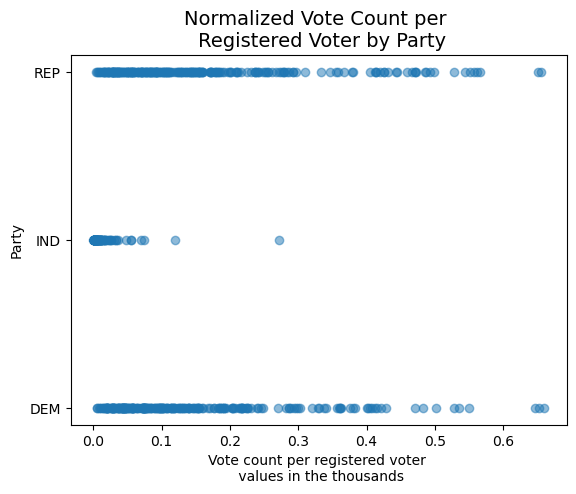

In [45]:
import matplotlib.pyplot as plt

plt.scatter(result['Vote count per registered voter'], 
            result.index.get_level_values('Party'),
           alpha=0.5)
plt.xlabel('Vote count per registered voter \n values in the thousands')
plt.ylabel('Party')
plt.title('Normalized Vote Count per \n Registered Voter by Party', fontdict={'fontsize': 14})

plt.show()

# SELECT * FROM results ORDER BY "Year", "State" DESC LIMIT 10;
# SELECT * FROM results WHERE "Year" = 2012;

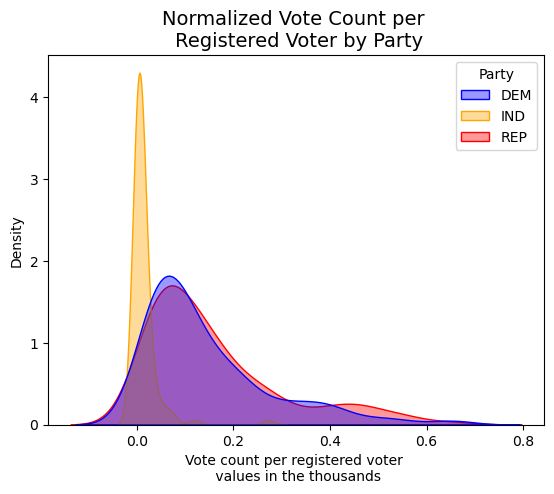

In [47]:
import seaborn as sns

sns.kdeplot(data=result, x='Vote count per registered voter', 
            hue='Party', fill=True,
             palette={'DEM': 'blue', 'REP': 'red', 'IND': 'orange'}, 
             alpha=0.4)

plt.xlabel('Vote count per registered voter \n values in the thousands')
plt.ylabel('Density')
plt.title('Normalized Vote Count per \n Registered Voter by Party', fontdict={'fontsize': 14})

plt.show()


In [48]:
# Group the data by year, office, and state and calculate the mean vote percentage
results = results_df.groupby(['Year', 'Party', 'State'])['Vote %'].mean()

# Print the results
results

Year  Party  State
2010  DEM    AK       0.269142
             AL       0.476881
             AR       0.407568
             AS       0.564051
             AZ       0.432068
                        ...   
2020  REP    VT       0.288402
             WA       0.431706
             WI       0.504417
             WV       0.684596
             WY       0.703601
Name: Vote %, Length: 754, dtype: float64

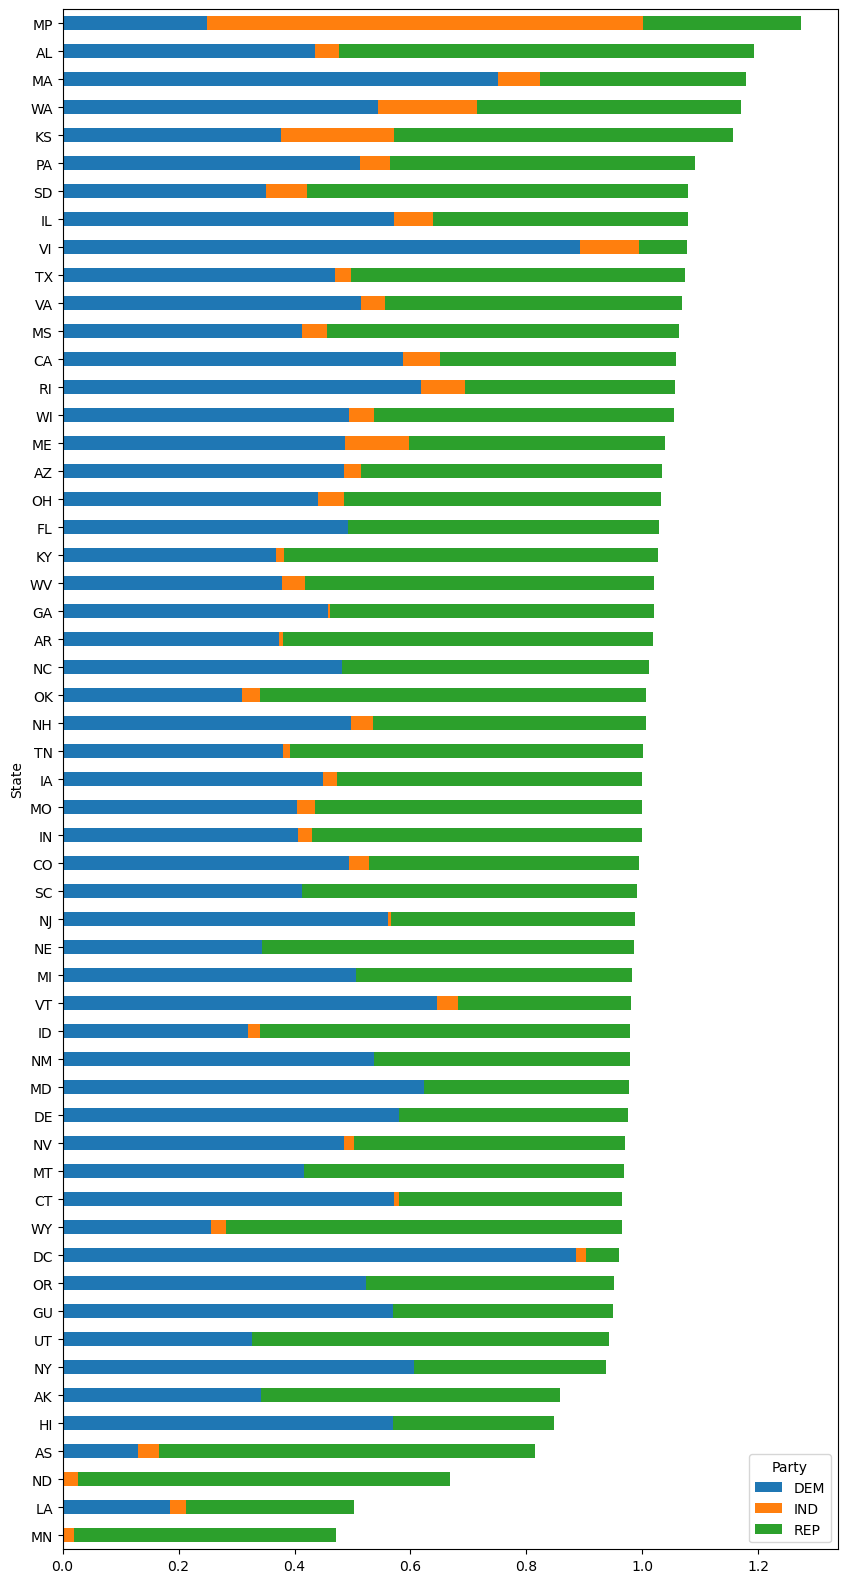

In [49]:
# Group the data by state and party and calculate the mean vote percentage
results1 = results_df.groupby(['State', 'Party'])['Vote %'].mean().unstack()

# Calculate the total vote percentage for each state
results1['Total'] = results1.sum(axis=1)

# Sort the data in descending order by total vote percentage
results1 = results1.sort_values(by='Total', ascending=True)

# Create a sideways bar chart for the three parties IND in the middle at 0.
fig, ax = plt.subplots(figsize=(10, 20))
results1.drop('Total', axis=1).plot(kind='barh', stacked=True, ax=ax)

# Show the chart
plt.show()

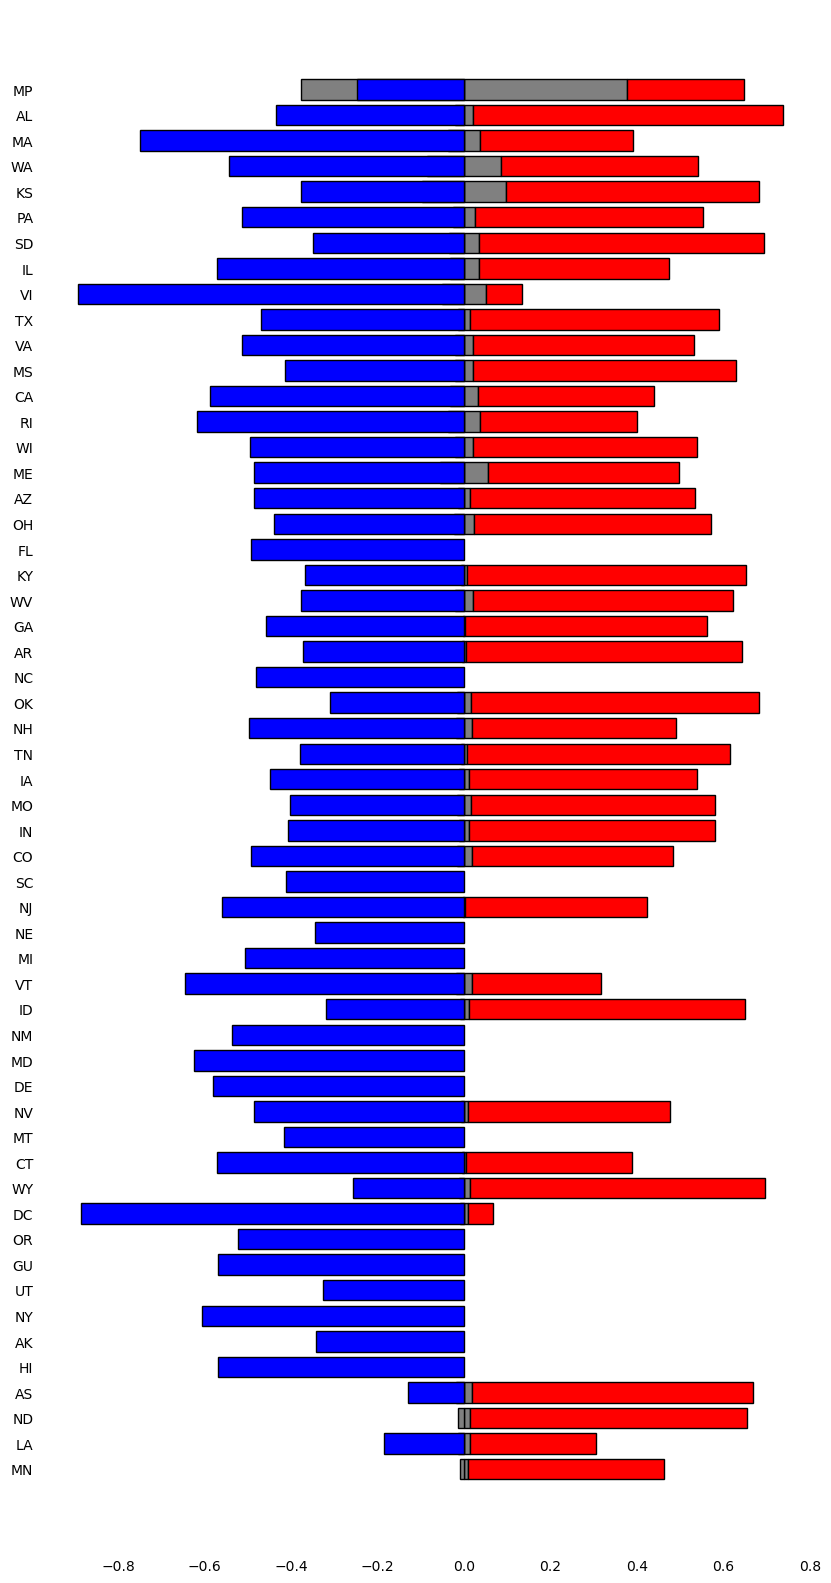

In [50]:
# Group the data by state and party and calculate the mean vote percentage
results1 = results_df.groupby(['State', 'Party'])['Vote %'].mean().unstack()

# Add missing parties with 0 vote percentage
results1 = results1.reindex(columns=['DEM', 'REP', 'IND'], fill_value=0)

# Calculate the total vote percentage for each state
results1['Total'] = results1.sum(axis=1)

# Sort the data in descending order by total vote percentage
results1 = results1.sort_values(by='Total', ascending=True)

# Create a pyramid bar chart
fig, ax = plt.subplots(figsize=(10, 20))

# Add the right half of the IND bar
ax.barh(results1.index, results1['IND'] / 2, align='center', color='gray', edgecolor='black')

# Add the REP bars
ax.barh(results1.index, results1['REP'], align='center', color='red', edgecolor='black', left=results1['IND'] / 2)

# Add the left half of the IND bar
ax.barh(results1.index, -results1['IND'] / 2, align='center', color='gray', edgecolor='black')

# Add the DEM bars
ax.barh(results1.index, -results1['DEM'], align='center', color='blue', edgecolor='black')

# Remove spines and ticks on top and bottom
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(top=False, bottom=False, left=False, right=False)

# Show the chart
plt.show()


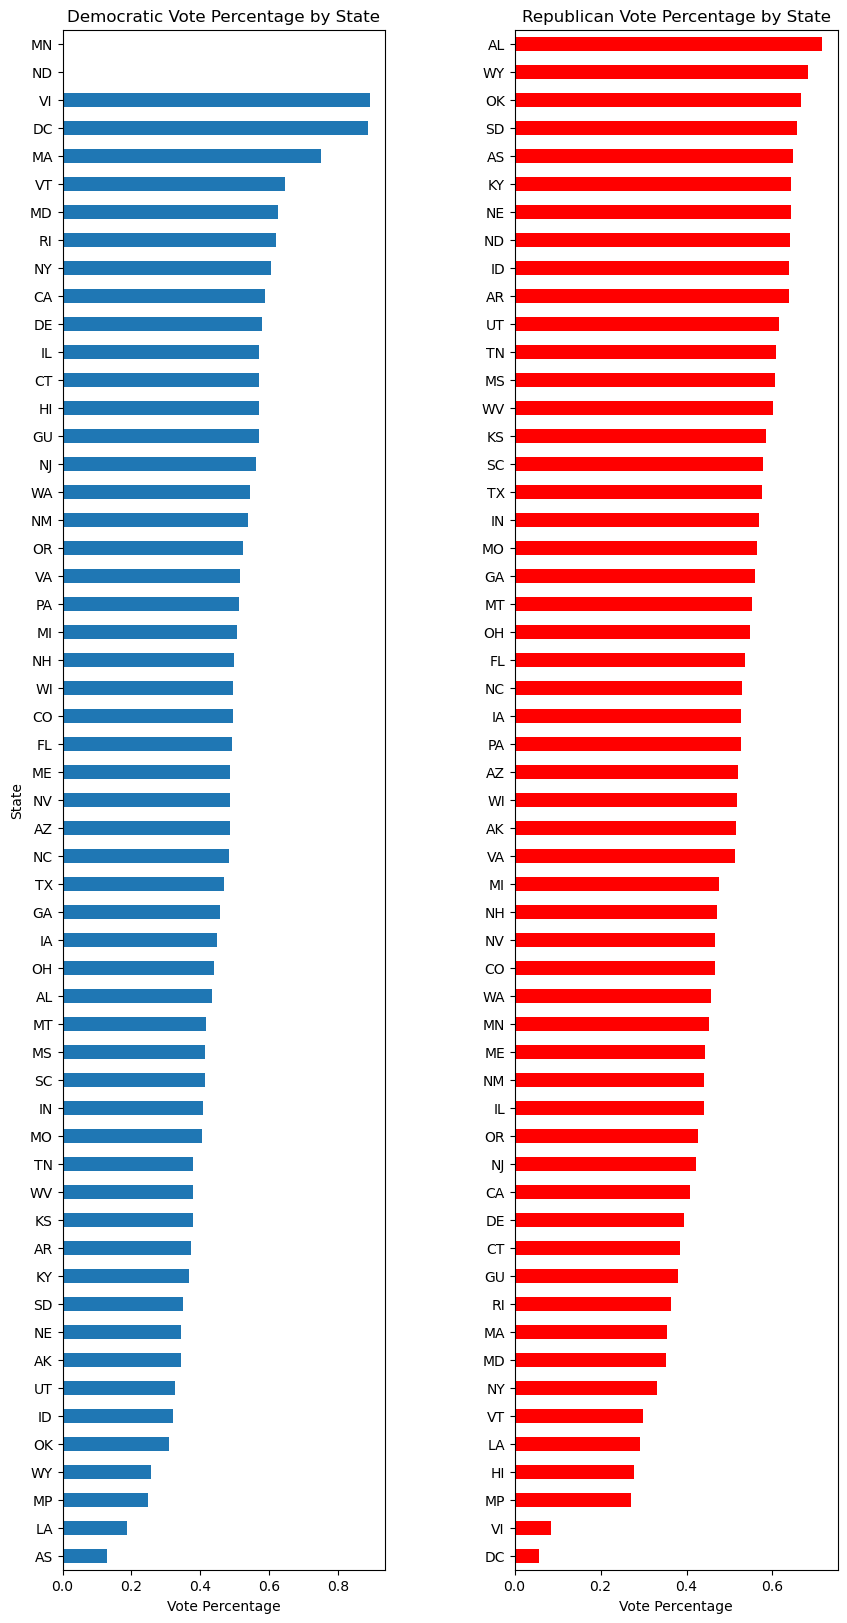

In [51]:
import matplotlib.pyplot as plt

# Group the data by state and party and calculate the mean vote percentage
results_df['Party'] = results_df['Party'].replace({'DEM': 'Democratic', 'REP': 'Republican'})
results2 = results_df.groupby(['State', 'Party'])['Vote %'].mean().unstack()

# Sort the data in descending order by vote percentage
results2 = results2.sort_values(by='Republican', ascending=False)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 20))

# Create the first subplot for the Democratic vote percentages
results2['Democratic'].sort_values().plot(kind='barh', ax=ax1)
ax1.set_title('Democratic Vote Percentage by State')
ax1.set_xlabel('Vote Percentage')
ax1.set_ylabel('State')

# Create the second subplot for the Republican vote percentages
results2['Republican'].sort_values().plot(kind='barh', ax=ax2, color='red')
ax2.set_title('Republican Vote Percentage by State')
ax2.set_xlabel('Vote Percentage')
ax2.set_ylabel('')

# Adjust the layout and spacing between the subplots
plt.subplots_adjust(wspace=0.4)

# Show the chart
plt.show()


In [53]:
# # Regions: west=w, southwest=sw, midwest=mw, northeast=ne, southeast=se, t=territories
# w = ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'CO', 'AK', 'HI']
# sw = ['AZ', 'NM', 'TX', 'OK']
# mw = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']
# ne = ['ME', 'NH', 'VT', 'MA', 'NY', 'RI', 'CT', 'NJ', 'PA', 'MD']
# se = ['DE', 'WV', 'DC', 'VA', 'KY', 'TN', 'NC', 'SC', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL']
# # Territories: American Samoa=AS, Guam=GU, Northern Mariana Islands=MP, Puerto Rico=PR, Trust Territories=TT, Virgin Islands=VI,
# t = ['AS', 'GU', 'MP', 'PR', 'TT', 'VI']


# Create a dictionary to map states to regions
# Regions, west=w, southwest=sw, midwest=mw, northeast=ne, southeast=se
# Territories: American Samoa=AS, Guam=GU, Northern Mariana Islands=MP, Virgin Islands=VI
region_dict = {
    'w': ['HI', 'CA', 'WA', 'OR', 'CO', 'NV', 'MT', 'AK', 'UT', 'ID', 'WY'],
    'sw': ['NM', 'AZ', 'TX', 'OK'],
    'mw': ['IL', 'MI', 'WI', 'IA', 'OH', 'MO', 'IN', 'KS', 'SD', 'NE', 'ND', 'MN'],
    'ne': ['MA', 'VT', 'MD', 'NY', 'CT', 'NJ', 'RI', 'PA', 'NH', 'ME'],
    'se': ['DC', 'DE', 'VA', 'FL', 'NC', 'GA', 'SC', 'MS', 'AL', 'TN', 'WV', 'KY', 'AR', 'LA'],
    't': ['VI', 'GU', 'MP', 'AS']
}

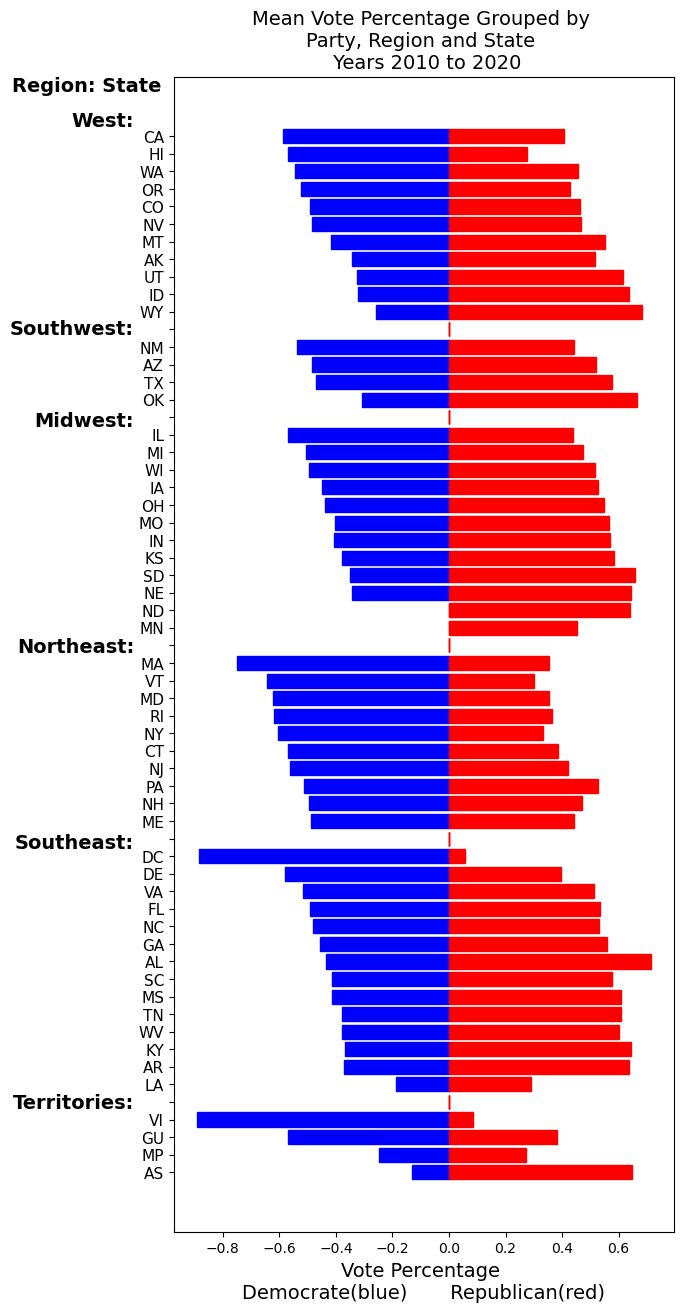

In [127]:
# import matplotlib.pyplot as plt
region_dict = {
    'w': w,
    'sw': sw,
    'mw': mw,
    'ne': ne,
    'se': se,
    't': t
}

# region_dict = {
#     'w': ['HI', 'CA', 'WA', 'OR', 'CO', 'NV', 'MT', 'AK', 'UT', 'ID', 'WY'],
#     'sw': ['NM', 'AZ', 'TX', 'OK'],
#     'mw': ['IL', 'MI', 'WI', 'IA', 'OH', 'MO', 'IN', 'KS', 'SD', 'NE', 'ND', 'MN'],
#     'ne': ['MA', 'VT', 'MD', 'NY', 'CT', 'NJ', 'RI', 'PA', 'NH', 'ME'],
#     'se': ['DC', 'DE', 'VA', 'FL', 'NC', 'GA', 'SC', 'MS', 'AL', 'TN', 'WV', 'KY', 'AR', 'LA'],
#     't': ['VI', 'GU', 'MP', 'AS']
# }

# Group the data by state and party and calculate the mean vote percentage
results_df['Party'] = results_df['Party'].replace({'DEM': 'Democratic', 'REP': 'Republican'})
results2 = results_df.groupby(['State', 'Party'])['Vote %'].mean().unstack()

# Create a figure and a single subplot
fig, ax = plt.subplots(figsize=(10, 15))

# Create a horizontal bar chart with the Democratic vote percentages pointing left
data = []
y_coords = []
for i, state in enumerate(w + [''] + sw + [''] + mw + [''] + ne + [''] + se + [''] + t):
    if state in results2.index:
        data.append(results2.loc[state, 'Republican'])  # Append Republican value first
        data.append(-results2.loc[state, 'Democratic'])  # Append negative Democratic value second
        data.append(0)  # Add a blank bar to separate each region group
        y_coords.append(i)  # Add y-coordinate for the state
        y_coords.append(i)  # Add y-coordinate for the blank bar
        y_coords.append(i)  # Add y-coordinate for the Republican value
    else:
        data.extend([0] * 3)  # Add 3 zero-width bars if the state is not in the data
        y_coords.extend([i] * 3)  # Add y-coordinates for the blank bars

# Set the y-ticks and y-tick labels with a space between region groups
yticks = w + [''] + sw + [''] + mw + [''] + ne + [''] + se + [''] + t
ax.set_yticks(range(len(yticks)))
ax.set_yticklabels(yticks, fontsize='11')

# Create the bar chart with the corrected y-coordinates
bars = ax.barh(y_coords, data, color=['red', 'blue'], align='center')

# Set the color of each bar based on the value
for bar in bars:
    if bar.get_width() < 0:
        bar.set_color('blue')
    else:
        bar.set_color('red')

# Set the title and axis labels
ax.set_title('Mean Vote Percentage Grouped by \nParty, Region and State \n Years 2010 to 2020', fontsize='14')
ax.set_xlabel('Vote Percentage \nDemocrate(blue)       Republican(red)', fontsize='14')
ax.set_ylabel('')

# Add labels for each region
ax.text(-0.025, 1, 'Region: State', transform=ax.transAxes, ha='right', va='top', weight='bold', fontsize='14')
ax.text(-0.08, 0.97, 'West:', transform=ax.transAxes, ha='right', va='top', weight='bold', fontsize='14')
ax.text(-0.08, 0.79, 'Southwest:', transform=ax.transAxes, ha='right', va='top', weight='bold', fontsize='14')
ax.text(-0.08, 0.71, 'Midwest:', transform=ax.transAxes, ha='right', va='top', weight='bold', fontsize='14')
ax.text(-0.08, 0.515, 'Northeast:', transform=ax.transAxes, ha='right', va='top', weight='bold', fontsize='14')
ax.text(-0.08, 0.345, 'Southeast:', transform=ax.transAxes, ha='right', va='top', weight='bold', fontsize='14')
ax.text(-0.08, 0.12, 'Territories:', transform=ax.transAxes, ha='right', va='top', weight='bold', fontsize='14')

# Invert the y-axis and adjust
plt.gca().invert_yaxis()
plt.subplots_adjust(left=0.4)

# Show the chart
plt.show()


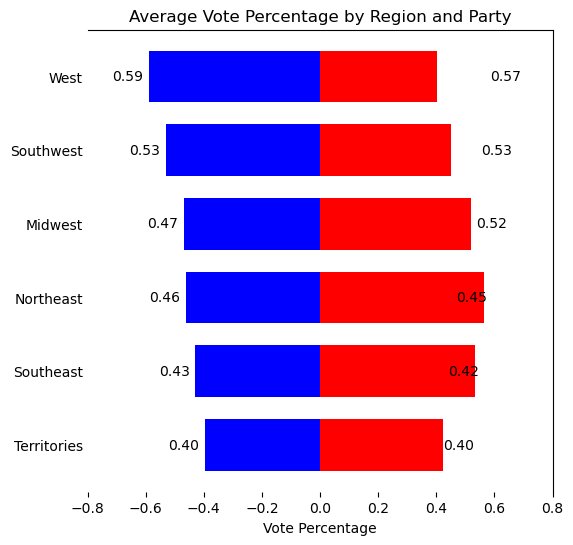

In [64]:
# import matplotlib.pyplot as plt

# # Regions, west=w, southwest=sw, midwest=mw, northeast=ne, southeast=se
# w = ['WA', 'OR', 'CA', 'ID', 'NV', 'MT', 'WY', 'UT', 'CO', 'AK', 'HI']
# sw = ['AZ', 'NM', 'TX', 'OK']
# mw = ['ND', 'SD', 'NE', 'KS', 'MN', 'IA', 'MO', 'WI', 'IL', 'MI', 'IN', 'OH']
# ne = ['ME', 'NH', 'VT', 'MA', 'NY', 'RI', 'CT', 'NJ', 'PA', 'MD']
# se = ['DE', 'WV', 'DC', 'VA', 'KY', 'TN', 'NC', 'SC', 'AR', 'LA', 'MS', 'AL', 'GA', 'FL']
# # Territories: American Samoa=AS, Guam=GU, Northern Mariana Islands=MP, Virgin Islands=VI,
# t = ['AS', 'GU', 'MP', 'VI']


w = ['CA', 'HI', 'WA', 'OR', 'CO', 'NV', 'MT', 'AK', 'UT', 'ID', 'WY']
sw = ['NM', 'AZ', 'TX', 'OK']
mw = ['IL', 'MI', 'WI', 'IA', 'OH', 'MO', 'IN', 'KS', 'SD', 'NE', 'ND', 'MN']
ne = ['MA', 'VT', 'MD', 'RI', 'NY', 'CT', 'NJ', 'PA', 'NH', 'ME']
se = ['DC', 'DE', 'VA', 'FL', 'NC', 'GA', 'AL', 'SC', 'MS', 'TN', 'WV', 'KY', 'AR', 'LA']
t = ['VI', 'GU', 'MP', 'AS']

# Create a dictionary that maps each state to its region
state_to_region = {}
for state in w:
    state_to_region[state] = 'West'
for state in sw:
    state_to_region[state] = 'Southwest'
for state in mw:
    state_to_region[state] = 'Midwest'
for state in ne:
    state_to_region[state] = 'Northeast'
for state in se:
    state_to_region[state] = 'Southeast'
for state in t:
    state_to_region[state] = 'Territory'  

# Group the data by region and party and calculate the mean vote percentage
results_df['Party'] = results_df['Party'].replace({'DEM': 'Democratic', 'REP': 'Republican'})
results_df['Region'] = results_df['State'].apply(lambda x: state_to_region[x])
results2 = results_df.groupby(['Region', 'Party'])['Vote %'].mean().unstack()

# Sort the data in descending order by vote percentage
results2 = results2.sort_values(by='Republican', ascending=False)

# Create a figure with a single subplot
fig, ax = plt.subplots(figsize=(6, 6))

# Create the bar chart with blue bars pointing left and red bars pointing right
dem_votes = results2['Democratic'].sort_values()
rep_votes = results2['Republican'].sort_values()
ax.barh(dem_votes.index, -dem_votes, color='blue', align='center', height=0.7)
ax.barh(rep_votes.index, rep_votes, color='red', align='center', height=0.7)

# Add labels and formatting
ax.set_title('Average Vote Percentage by Region and Party')
ax.set_xlabel('Vote Percentage')
# ax.set_yticklabels(['West', 'Southwest', 'Midwest', 'Northeast', 'Southeast', 'Territories'])
ax.set_yticklabels(['Territories', 'Southeast', 'Northeast', 'Midwest', 'Southwest', 'West'])
ax.set_xticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
ax.xaxis.tick_bottom()
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.tick_params(axis='y', length=0)

# Add value labels to the bars
for i, v in enumerate(dem_votes):
    ax.text(-v - 0.02, i, f'{v:.2f}', color='black', ha='right', va='center')
for i, v in enumerate(rep_votes):
    ax.text(v + 0.02, i, f'{v:.2f}', color='black', ha='left', va='center')

# Show the chart
plt.show()


### Which party has the highest overall vote percentage across all offices and states
Use simple grouping or aggregation technique to calculate the average vote percentage for each party.

### Are there any patterns or trends in the vote percentage over time?
Use a time series analysis technique such as ARIMA or Prophet to model the trends and patterns in the vote percentage over time.

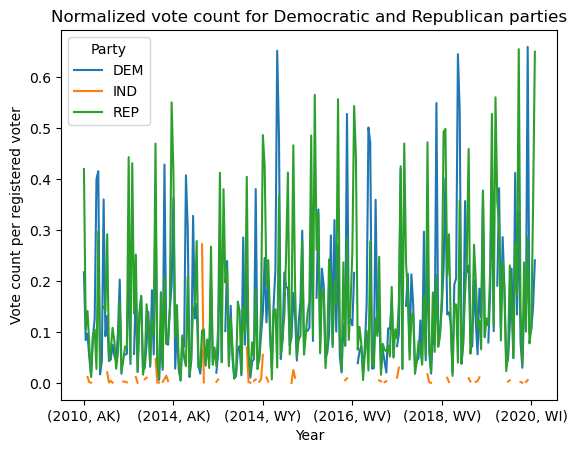

In [56]:
import pandas as pd
import matplotlib.pyplot as plt

# Subset merged dataframe to only include Democratic and Republican parties
subset_df = merged_df.loc[merged_df['Party'].isin(['Democratic', 'Republican'])]

# Group by year and party and calculate mean of normalized vote count
# Group merged_df by year, party, and state and calculate mean of normalized vote count
result = merged_df.groupby(['Year', 'Party', 'State'])[['Vote count', 'Registered']].mean()
result['Vote count per registered voter'] = result['Vote count'] / result['Registered']


# Reshape data so that Democratic and Republican vote counts are in separate columns
wide_df = result.unstack(level=1)['Vote count per registered voter']

# Create line plot of Democratic and Republican vote counts over time
wide_df.plot(kind='line')
plt.xlabel('Year')
plt.ylabel('Vote count per registered voter')
plt.title('Normalized vote count for Democratic and Republican parties')
plt.show()


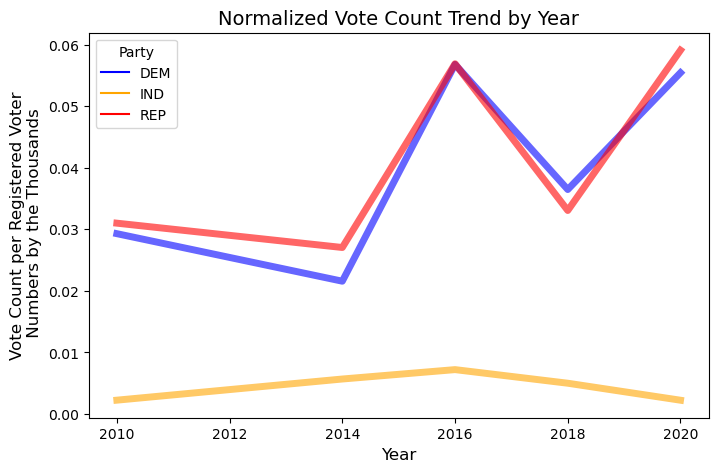

In [58]:
# Group merged_df by year, party, and state and calculate mean of normalized vote count
result = merged_df.groupby(['Year', 'Party'])[['Vote count', 'Registered']].mean()
result['Vote count per registered voter'] = result['Vote count'] / result['Registered']

# Create plot
fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=result, x='Year', y='Vote count per registered voter', 
             hue='Party',
             palette={'DEM': 'blue', 'REP': 'red', 'IND': 'orange'}, 
             ax=ax, linewidth=5, alpha=0.6)

# Set plot title and axis labels
ax.set_title('Normalized Vote Count Trend by Year', fontsize=14)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Vote Count per Registered Voter\n Numbers by the Thousands', fontsize=12)

# Show plot
plt.show()


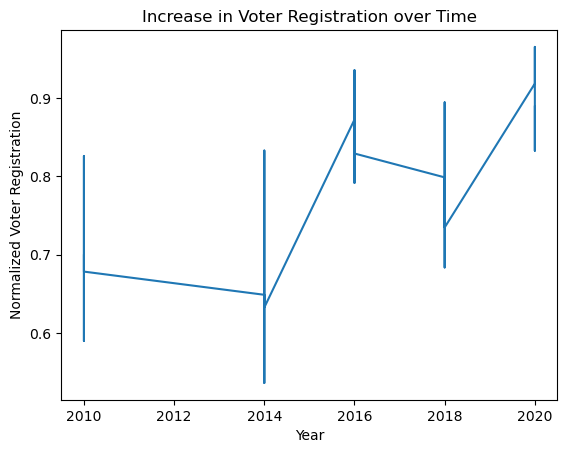

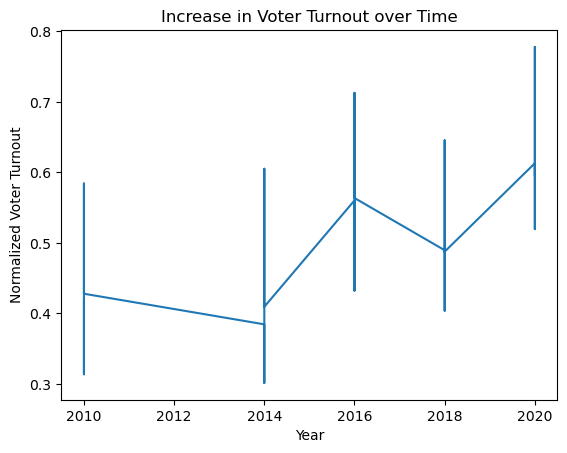

In [71]:
import matplotlib.pyplot as plt

# Create a line chart of Norm_Voter_Reg against Year
plt.plot(voters_df.Year, voters_df.Norm_Voter_Reg)
plt.xlabel('Year')
plt.ylabel('Normalized Voter Registration')
plt.title('Increase in Voter Registration over Time')
plt.show()

# Create a line chart of Norm_Voter_Pop against Year
plt.plot(voters_df.Year, voters_df.Norm_Voter_Pop)
plt.xlabel('Year')
plt.ylabel('Normalized Voter Turnout')
plt.title('Increase in Voter Turnout over Time')
plt.show()


In [ ]:
# t = ['AS', 'GU', 'MP', 'PR', 'TT', 'VI']

# # Specify the order of the legend labels
# legend_handles, legend_labels = plt.gca().get_legend_handles_labels()
# legend_labels = ['West', 'Southwest', 'Midwest', 'Northeast', 'Southeast', 'Territory']
# # legend_handles = [legend_handles[legend_labels.index(label)] for label in legend_labels]

# # Display the legend
# plt.legend(handles=legend_handles, labels=legend_labels)
    

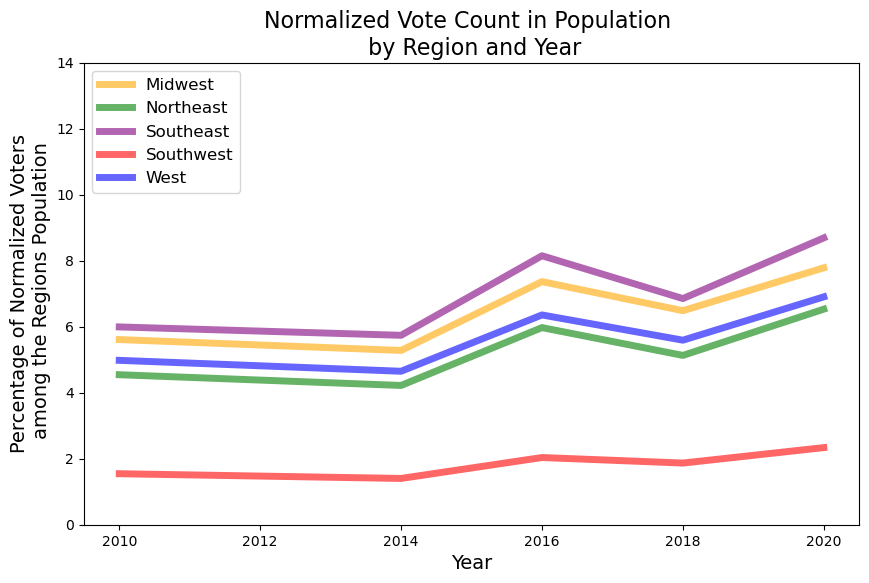

In [119]:
import matplotlib.pyplot as plt


w = ['CA', 'HI', 'WA', 'OR', 'CO', 'NV', 'MT', 'AK', 'UT', 'ID', 'WY']
sw = ['NM', 'AZ', 'TX', 'OK']
mw = ['IL', 'MI', 'WI', 'IA', 'OH', 'MO', 'IN', 'KS', 'SD', 'NE', 'ND', 'MN']
ne = ['MA', 'VT', 'MD', 'RI', 'NY', 'CT', 'NJ', 'PA', 'NH', 'ME']
se = ['DC', 'DE', 'VA', 'FL', 'NC', 'GA', 'AL', 'SC', 'MS', 'TN', 'WV', 'KY', 'AR', 'LA']
t = ['VI', 'GU', 'MP', 'AS']

# Create a dictionary that maps each state to its region
state_to_region = {}
for state in w:
    state_to_region[state] = 'West'
for state in sw:
    state_to_region[state] = 'Southwest'
for state in mw:
    state_to_region[state] = 'Midwest'
for state in ne:
    state_to_region[state] = 'Northeast'
for state in se:
    state_to_region[state] = 'Southeast'
for state in t:
    state_to_region[state] = 'Territory'

# Define a color palette for each region
color_palette = {
    'West': 'blue',
    'Southwest': 'red',
    'Midwest': 'orange',
    'Northeast': 'green',
    'Southeast': 'purple',
    'Territory': 'gray'
}

# Add a new column to the DataFrame that maps each state to its region
voters_df['Region'] = voters_df['State'].map(state_to_region)

# Group by the region column and sum the values
pop_region_df = voters_df.groupby(['Year', 'Region'])[['Norm_Voter_Pop']].sum().reset_index()
# reg_region_df = voters_df.groupby(['Year', 'Region'])[['Norm_Voter_Reg']].sum().reset_index()

# Plot the line chart
fig, ax = plt.subplots(figsize=(10, 6))
for region in pop_region_df['Region'].unique():
    df = pop_region_df[pop_region_df['Region'] == region]
    ax.plot(df['Year'], df['Norm_Voter_Pop'], label=region, linewidth=5, alpha=0.6, color=color_palette[region])
    
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Percentage of Normalized Voters\n among the Regions Population', fontsize=14)
ax.set_title('Normalized Vote Count in Population \n by Region and Year', fontsize=16)
# Set the y-axis limit to 13
ax.set_ylim(0, 14)
ax.legend(fontsize=12, loc='upper left')
plt.show()


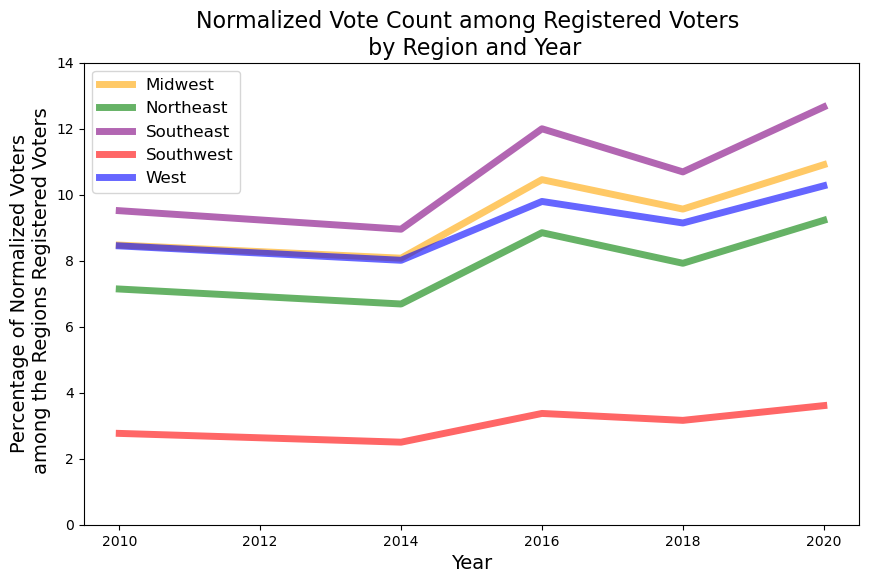

In [116]:
import matplotlib.pyplot as plt


w = ['CA', 'HI', 'WA', 'OR', 'CO', 'NV', 'MT', 'AK', 'UT', 'ID', 'WY']
sw = ['NM', 'AZ', 'TX', 'OK']
mw = ['IL', 'MI', 'WI', 'IA', 'OH', 'MO', 'IN', 'KS', 'SD', 'NE', 'ND', 'MN']
ne = ['MA', 'VT', 'MD', 'RI', 'NY', 'CT', 'NJ', 'PA', 'NH', 'ME']
se = ['DC', 'DE', 'VA', 'FL', 'NC', 'GA', 'AL', 'SC', 'MS', 'TN', 'WV', 'KY', 'AR', 'LA']
t = ['VI', 'GU', 'MP', 'AS']

# Create a dictionary that maps each state to its region
state_to_region = {}
for state in w:
    state_to_region[state] = 'West'
for state in sw:
    state_to_region[state] = 'Southwest'
for state in mw:
    state_to_region[state] = 'Midwest'
for state in ne:
    state_to_region[state] = 'Northeast'
for state in se:
    state_to_region[state] = 'Southeast'
for state in t:
    state_to_region[state] = 'Territory'

# Define a color palette for each region
color_palette = {
    'West': 'blue',
    'Southwest': 'red',
    'Midwest': 'orange',
    'Northeast': 'green',
    'Southeast': 'purple',
    'Territory': 'gray'
}

# Add a new column to the DataFrame that maps each state to its region
voters_df['Region'] = voters_df['State'].map(state_to_region)

# Group by the region column and sum the values
# pop_region_df = voters_df.groupby(['Year', 'Region'])[['Norm_Voter_Pop']].sum().reset_index()
reg_region_df = voters_df.groupby(['Year', 'Region'])[['Norm_Voter_Reg']].sum().reset_index()

# Plot the line chart
fig, ax = plt.subplots(figsize=(10, 6))
for region in reg_region_df['Region'].unique():
    df = reg_region_df[reg_region_df['Region'] == region]
    ax.plot(df['Year'], df['Norm_Voter_Reg'], label=region, linewidth=5, alpha=0.6, color=color_palette[region])
    
ax.set_xlabel('Year', fontsize=14)
ax.set_ylabel('Percentage of Normalized Voters\n among the Regions Registered Voters', fontsize=14)
ax.set_title('Normalized Vote Count among Registered Voters \n by Region and Year', fontsize=16)
# Set the y-axis limit to 13
ax.set_ylim(0, 14)
ax.legend(fontsize=12)
plt.show()


In [100]:
voters_df['Region']


0      Southeast
1           West
2      Southwest
3      Southeast
4           West
         ...    
255         West
256    Southeast
257      Midwest
258         West
259          NaN
Name: Region, Length: 260, dtype: object

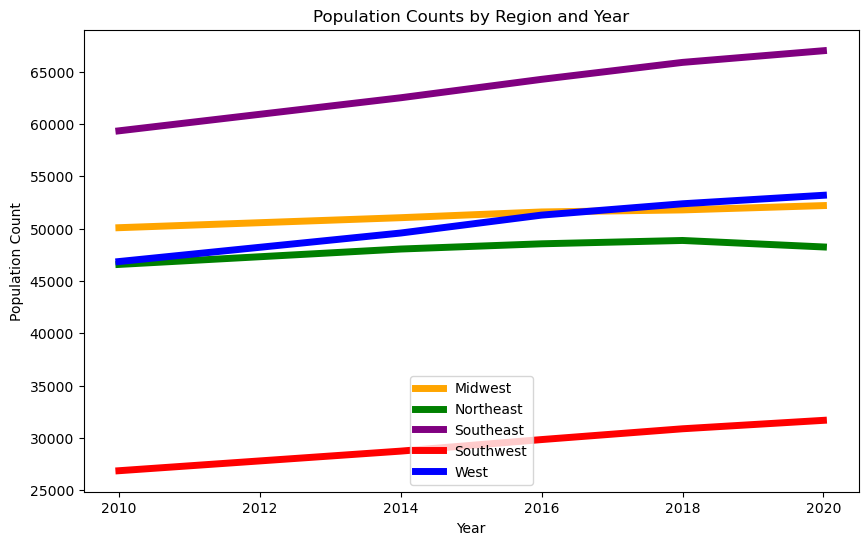

In [111]:
import matplotlib.pyplot as plt

# Create a dictionary that maps each state to its region
state_to_region = {}
for state in w:
    state_to_region[state] = 'West'
for state in sw:
    state_to_region[state] = 'Southwest'
for state in mw:
    state_to_region[state] = 'Midwest'
for state in ne:
    state_to_region[state] = 'Northeast'
for state in se:
    state_to_region[state] = 'Southeast'
for state in t:
    state_to_region[state] = 'Territory'

# Add a new column to the DataFrame that maps each state to its region
voters_df['Region'] = voters_df['State'].map(state_to_region)

# Group by the region column and sum the population values
region_df = voters_df.groupby(['Year', 'Region'])['Population'].sum().reset_index()

# Plot the line chart
fig, ax = plt.subplots(figsize=(10, 6))
for region in region_df['Region'].unique():
    df = region_df[region_df['Region'] == region]
    ax.plot(df['Year'], df['Population'], label=region, linewidth=5, color=color_palette[region])

ax.set_xlabel('Year')
ax.set_ylabel('Population Count')
ax.set_title('Population Counts by Region and Year')
ax.legend()
plt.show()


### Which factors (e.g., state, office, party) have the most influence on the vote percentage?
Use a regression model such as linear regression or decision tree regression to identify the most important factors that influence the vote percentage.

### Predict the vote percentage for a given office, state, and party combination based on historical data?
Use a machine learning model such as random forest regression or gradient boosting regression to predict the vote percentage based on historical data. We can also use feature engineering techniques to extract additional features such as the candidate's background, campaign spending, and demographics of the voters.

In [59]:
# Read file of new dataframe of all countries
temp_file = 'ESG_2_all.csv'
data = pd.read_csv(temp_file)

df_esg2_all = pd.DataFrame(data=data)
df_esg2_all = df_esg2_all.drop(df_esg2_all.index[[1433,1434,1435,1436,1437]])
print(df_esg2_all.head(7)) # view data
print(df_esg2_all.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'ESG_2_all.csv'

In [ ]:
# fig = plt.figure(figsize=(20,10))
fig=px.choropleth(df_esg2_all,locations='Ctry',
    locationmode='USA-states',animation_frame='Year',
    animation_group='Ctry',color='CO2',
    color_continuous_scale= 'reds' , hover_name='Ctry', 
    title = '<b>Global Co2 Levels per Capita Over the Last 24 Years:</b><br>Zoom in on the Middle East. Play animation below.')
fig.update_layout(margin={"r":0,"t":70,"l":0,"b":0})
fig.show()

In [45]:
# Show new dataframe
results_df.tail()

,Year,Office,State,Last Name,Party,Vote %,Vote count
6107,2010,House,WI,Kagen,Democratic,0.451232,118646
6108,2010,Senate,WI,Johnson,Republican,0.518575,1125999
6109,2010,Senate,WI,Feingold,Democratic,0.470199,1020958
6110,2010,House,WY,Lummis,Republican,0.704186,131661
6111,2010,House,WY,Wendt,Democratic,0.244789,45768


In [48]:
# fig = plt.figure(figsize=(20,10))
fig=px.choropleth(results_df,locations='State',
    locationmode='USA-states',animation_frame='Year',
    animation_group='State', color ='Vote %',
    color_continuous_scale= 'reds' , hover_name='State', 
    title = '<b>US Election Results 2010-2020:</b><br>Zoom in on the State of your choice. Play animation below.')
fig.update_layout(margin={"r":0,"t":70,"l":0,"b":0})
fig.show()

In [87]:
# Aggregate the data by year, state, and office, and calculate the party with the highest vote percentage
vote_agg_house_df = results_df[results_df['Office']=='House'].groupby(['Year', 'State', 'Office']).apply(lambda x: x.loc[x['Vote %'].idxmax()])[['Vote %', 'Party']].reset_index()
vote_agg_house_df

,Year,State,Office,Vote %,Party
0,2010,AK,House,0.689579,Republican
1,2010,AL,House,0.988175,Republican
2,2010,AR,House,0.724351,Republican
3,2010,AS,House,0.564051,Democratic
4,2010,AZ,House,0.669416,Democratic
...,...,...,...,...,...
267,2020,VT,House,0.673072,Democratic
268,2020,WA,House,0.829883,Democratic
269,2020,WI,House,0.746456,Democratic
270,2020,WV,House,0.713362,Republican


In [86]:
import plotly.express as px

# Aggregate the data by year, state, and office, and calculate the party with the highest vote percentage
vote_agg_house_df = results_df[results_df['Office']=='House'].groupby(['Year', 'State', 'Office']).apply(lambda x: x.loc[x['Vote %'].idxmax()])[['Vote %', 'Party']].reset_index()

# create map graph by: 
# Filter the dataframe to include only US states, including Alaska and Hawaii
us_states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']
results_us = results_df[results_df['State'].isin(us_states)]

# Define colors for each party
colors = {'REP': 'red', 'DEM': 'dodgerblue', 'IND': 'grey'}

# Define color labels
color_labels = {'REP': 'Republican', 'DEM': 'Democrat', 'IND': 'Independent'}


# Map the winner of each state to colors
vote_agg_house_df['colors'] = vote_agg_house_df['Party'].map(colors)

# Create the choropleth plot
fig = px.choropleth(results_us, locations='State',
                    locationmode='USA-states', animation_frame='Year',
                    animation_group='State', color='Party', 
                    color_continuous_scale='reds', hover_name='State',
                    scope='usa', range_color=[0, 1], 
                    title='<b>US Election Results 2010-2020:</b><br>Zoom in on the State of your choice. Play animation below.')

fig.update_layout(margin={"r":0,"t":70,"l":0,"b":0})

# Show the plot
fig.show()
